In [1]:
import torch
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

plt.style.use('dark_background')

print(torch.cuda.is_available())

True


In [2]:
data = pd.read_csv("./cleaned/usdrub.csv", index_col=0)

In [3]:
# data.to_csv('./aaa.csv', index=False)

In [4]:
data

,date,open,high,low,close,vol
33,2014-02-06,34.8934,34.9337,34.5848,34.7102,7669
34,2014-02-07,34.7300,34.8300,34.5300,34.7500,10
116,2014-05-05,35.7747,35.8635,35.6700,35.7100,1564
268,2014-10-07,39.7165,39.9751,39.6550,39.8873,376
269,2014-10-08,39.8959,40.1560,39.6877,39.9721,901
...,...,...,...,...,...,...
3404,2024-01-19,89.4213,89.5250,87.1000,88.0500,7931
3405,2024-01-21,88.0500,88.0500,88.0500,88.0500,2
3406,2024-01-22,88.0500,88.5650,86.9250,87.9932,2622
3407,2024-01-23,87.9000,88.8839,86.8250,88.6173,7594


In [5]:
from IPython.display import HTML, display

Check for stationarity

In [6]:
data['close']

33      34.7102
34      34.7500
116     35.7100
268     39.8873
269     39.9721
         ...   
3404    88.0500
3405    88.0500
3406    87.9932
3407    88.6173
3408    88.2400
Name: close, Length: 3122, dtype: float64

In [7]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['close'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.788866647615692
p-value: 0.05988177088603723
Critial Values:
   1%, -3.4324646145004256
Critial Values:
   5%, -2.862474304424197
Critial Values:
   10%, -2.567267353018705


Autocorrelations

In [8]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

<Figure size 1600x700 with 0 Axes>

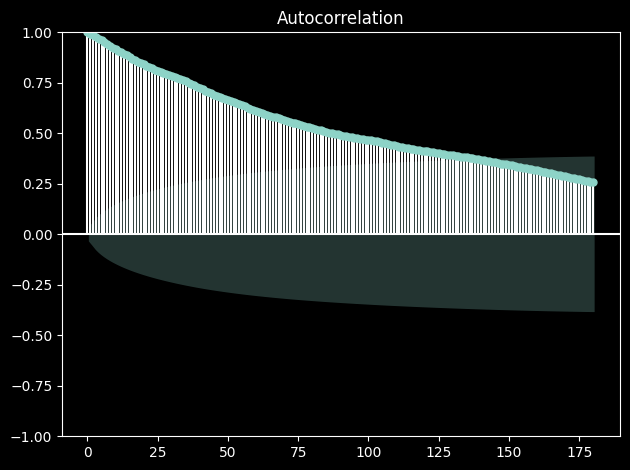

In [9]:
plt.figure(figsize=(16,7))
plot_acf(data['close'], fft=True, lags=180)
plt.tight_layout()
plt.show()

<Figure size 1600x700 with 0 Axes>

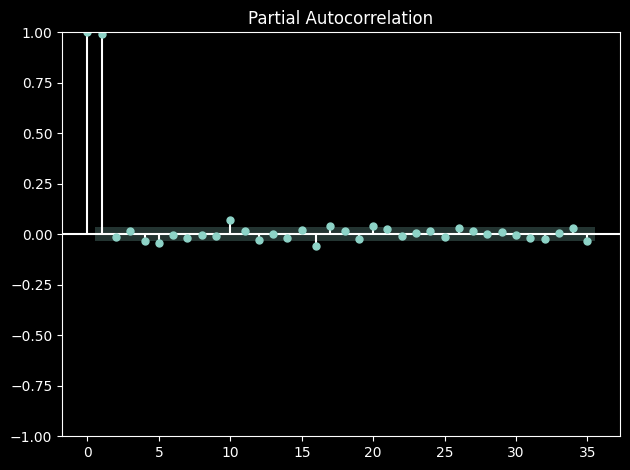

In [10]:
plt.figure(figsize=(16,7))
plot_pacf(data['close'])
plt.tight_layout()
plt.show()

Train test split and preparation

In [11]:
data = data.sort_values('date')
data = data.set_index('date')

In [12]:
train_length = int(len(data) * 0.8)
print('Train length: ', train_length)

train_data, test_data = data[:train_length], data[train_length:]
print('Shape of Train and Test data: ', len(train_data), len(test_data))

Train length:  2497
Shape of Train and Test data:  2497 625


In [13]:
from numpy import array

def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [14]:
lag = 3  # Empirically we have choosen
n_features = 1

In [15]:
train_X, train_y = split_sequence(train_data['close'], lag)
test_X, test_y = split_sequence(test_data['close'], lag)

C:\Users\igor\AppData\Local\Temp\ipykernel_13044\1544843132.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]


In [16]:
train_X

array([[34.7102, 34.75  , 35.71  ],
       [34.75  , 35.71  , 39.8873],
       [35.71  , 39.8873, 39.9721],
       ...,
       [76.6961, 76.2934, 75.7251],
       [76.2934, 75.7251, 75.5988],
       [75.7251, 75.5988, 74.764 ]])

In [17]:
train_y

array([39.8873, 39.9721, 43.0322, ..., 75.5988, 74.764 , 74.384 ])

In [18]:
train_X.shape, train_y.shape

((2494, 3), (2494,))

In [19]:
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], n_features))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))

In [20]:
# New shape of train_X and test_X are :-
print('Shape of train_X and train_y: ', train_X.shape, train_y.shape)
print('Shape of test_X and test_y: ', test_X.shape, test_y.shape)

Shape of train_X and train_y:  (2494, 3, 1) (2494,)
Shape of test_X and test_y:  (622, 3, 1) (622,)


Model

In [101]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [102]:
# # ok params
model = Sequential()
model.add(LSTM(16, 
               activation='relu', 
              #  dropout=0.7, 
               return_sequences=False, 
               input_shape=(lag, n_features))
)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

c:\Users\igor\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 16)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,169 (4.57 KB)

 Trainable params: 1,169 (4.57 KB)

 Non-trainable params: 0 (0.00 B)

In [103]:
history = model.fit(train_X, train_y, epochs = 3, batch_size=8, verbose=1, validation_split= 0.2)

Epoch 1/3


250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4300.3633 - val_loss: 5433.8994
Epoch 2/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - loss: 2149.5210 - val_loss: 0.4269
Epoch 3/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - loss: 0.9263 - val_loss: 0.3787


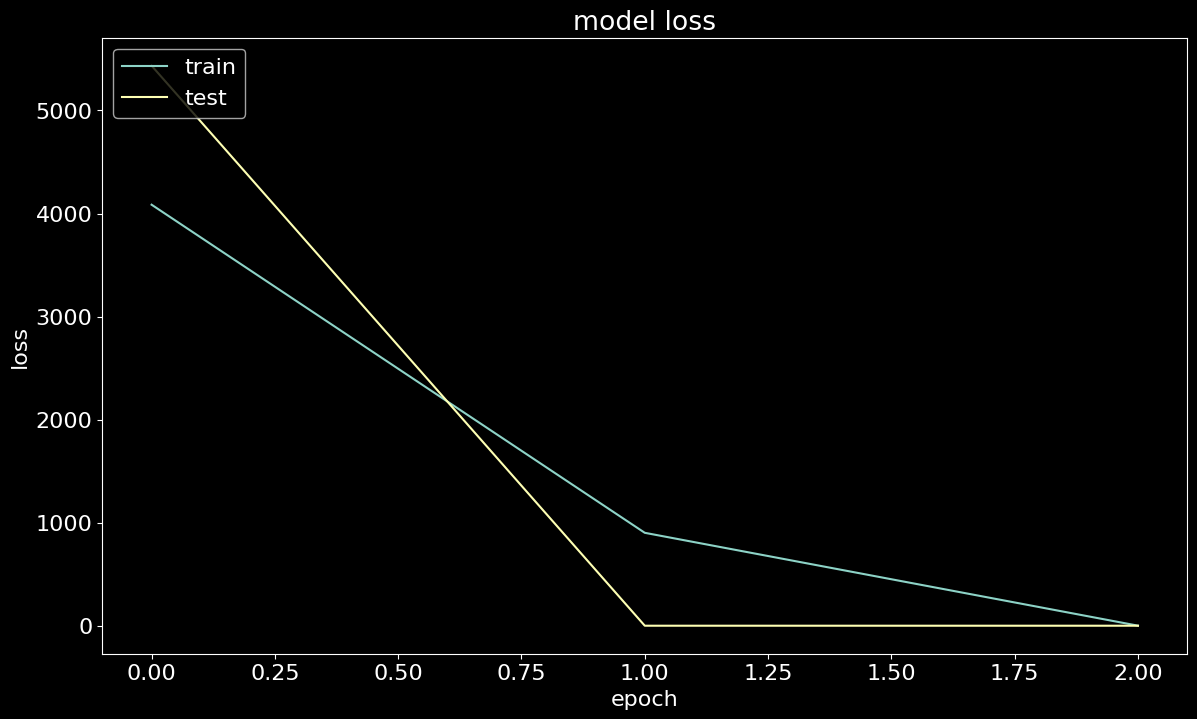

In [104]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [105]:
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

print('Shape of train and test predict: ', train_predict.shape, test_predict.shape)

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
Shape of train and test predict:  (2494, 1) (622, 1)


In [106]:
# root mean squared error or rmse
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

def measure_rmse(actual, predicted):
    return math.sqrt(mean_squared_error(actual, predicted))

def measure_mape(actual, predicted):
    return math.sqrt(mean_absolute_percentage_error(actual, predicted))

train_score = measure_rmse(train_y, train_predict)
test_score = measure_rmse(test_y, test_predict)

train_score_mape = measure_mape(train_y, train_predict)
test_score_mape = measure_mape(test_y, test_predict)

print('Train and Test RMSE: ', train_score, test_score)
print('Train and Test MAPE: ', train_score_mape, test_score_mape)

Train and Test RMSE:  0.8569440772515423 2.729055121305851
Train and Test MAPE:  0.09271188343398892 0.13511535835748373


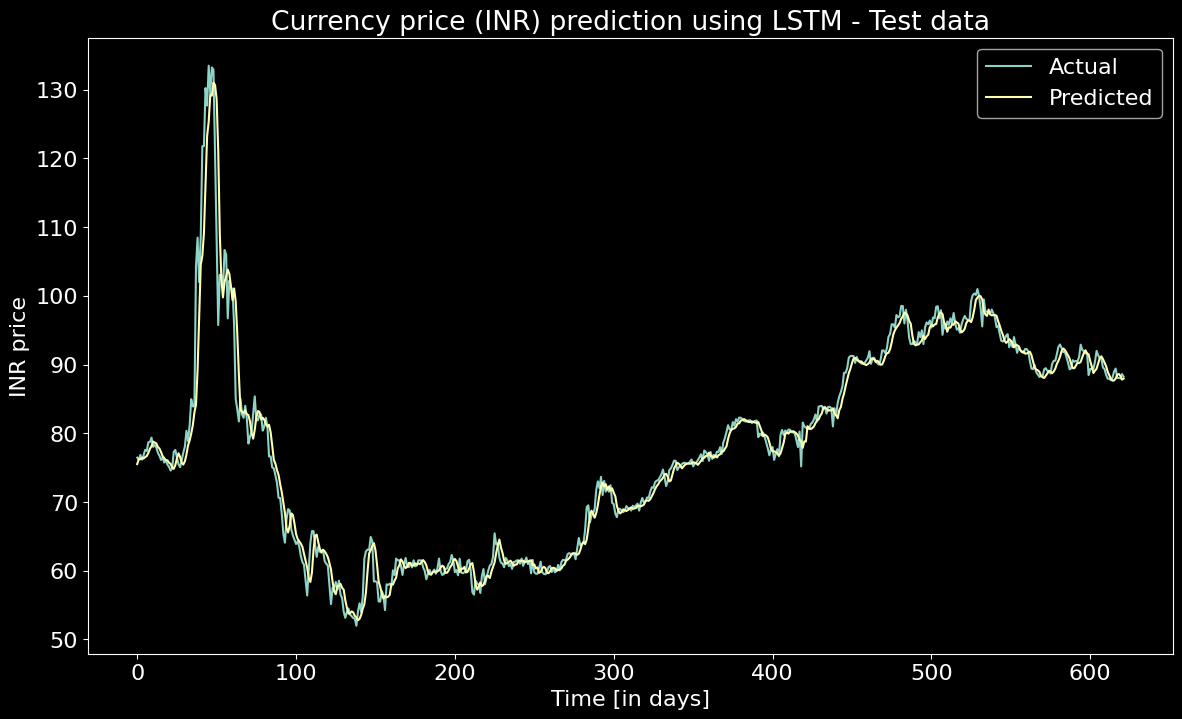

In [107]:
plt.rc("figure", figsize=(14,8))
plt.rcParams.update({'font.size': 16})
plt.plot(test_y, label = 'Actual')
plt.plot(test_predict, label = 'Predicted')
plt.xlabel('Time [in days]')
plt.ylabel('INR price')
plt.title('Currency price (INR) prediction using LSTM - Test data')
plt.legend()
plt.show()

In [108]:
train_predict

array([[34.42188 ],
       [35.876225],
       [37.721527],
       ...,
       [76.22838 ],
       [75.85104 ],
       [75.36201 ]], dtype=float32)

In [109]:
test_predict_np = test_predict.reshape((len(test_predict)))

In [110]:
test_predict_np.shape

(622,)

In [111]:
test_predict_random = test_data.close.to_numpy()

In [112]:
test_predict_random = pd.Series(test_y).shift(1).fillna(test_y[0])

In [113]:
test_predict_random.shape

(622,)

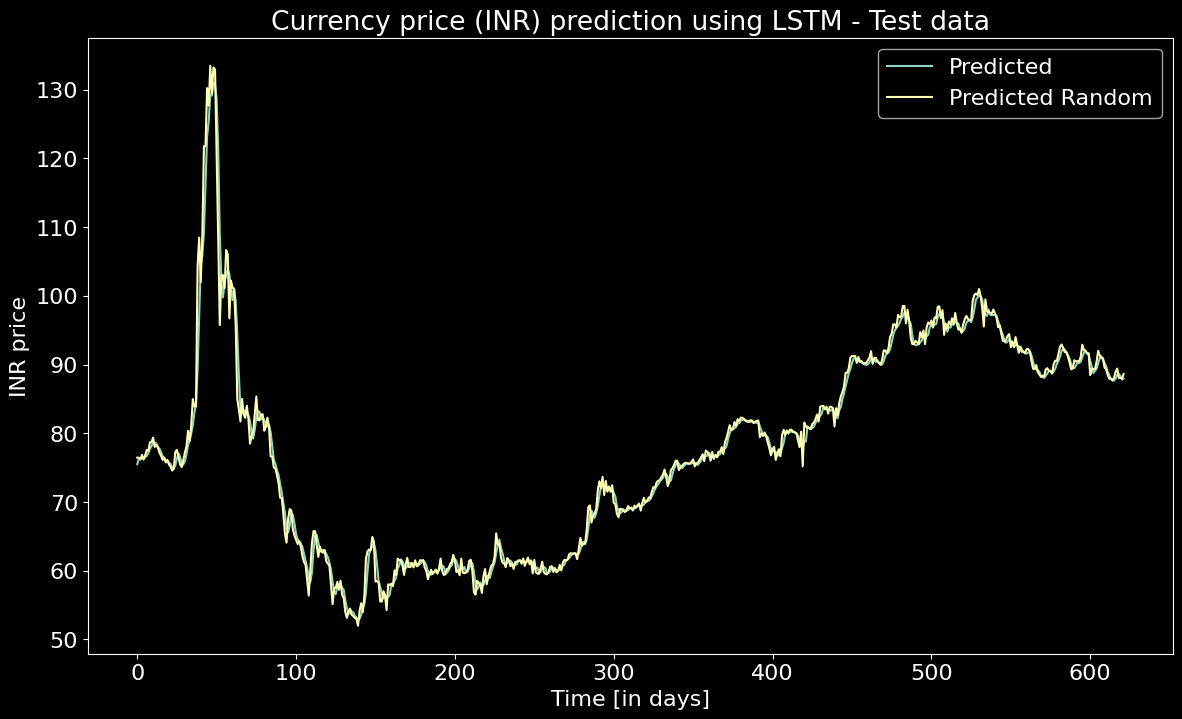

In [114]:
plt.rc("figure", figsize=(14,8))
plt.rcParams.update({'font.size': 16})
plt.plot(test_predict_np, label = 'Predicted')
plt.plot(test_predict_random, label = 'Predicted Random')
plt.xlabel('Time [in days]')
plt.ylabel('INR price')
plt.title('Currency price (INR) prediction using LSTM - Test data')
plt.legend()
plt.show()

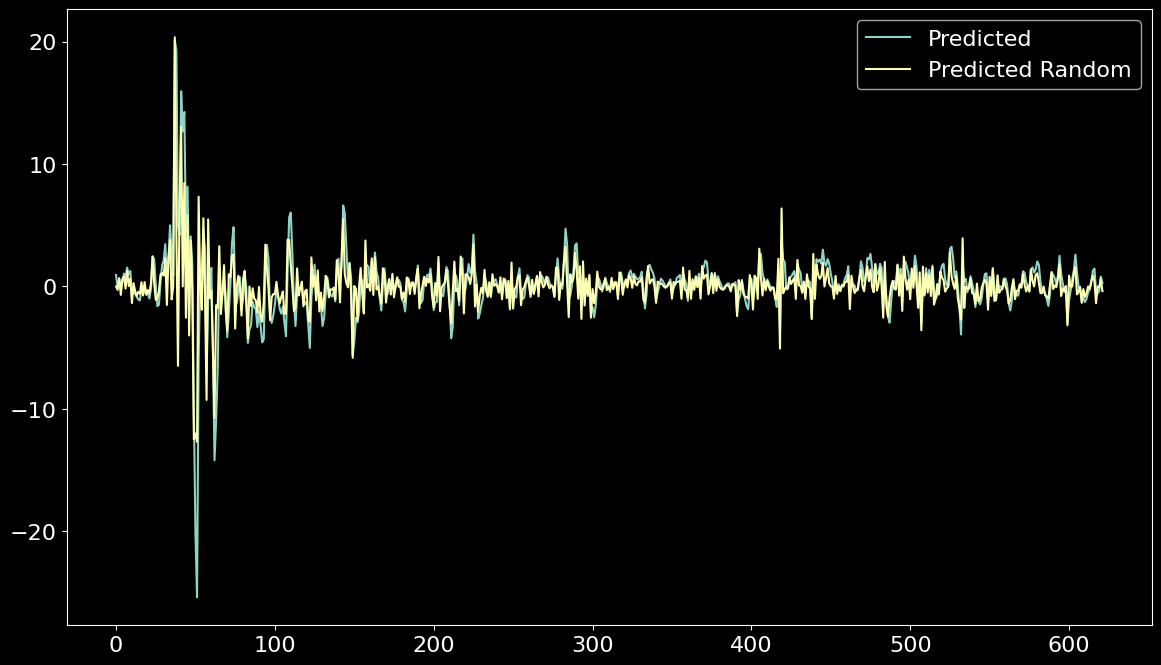

In [115]:
#Errors 
plt.plot(test_y -test_predict_np,label = 'Predicted')
plt.plot(test_y -test_predict_random, label = 'Predicted Random')
plt.legend()

In [116]:
(test_y - test_predict).mean()

0.1746041250149163

In [117]:
(test_y - test_predict_random).mean()

0.018958199356913185

Check predictions

In [118]:
def split_sequence_v2(sequence, n_steps):
    X = list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
    return array(X)

In [119]:
roll = data['close'].tail(4).reset_index(drop=True)

for i in range(100):
  last = split_sequence_v2(roll.tail(4), lag)
  last = last.reshape((last.shape[0], last.shape[1], n_features))
  last_pred = model.predict(last)
  roll = pd.concat([roll, pd.Series(last_pred[0])], ignore_index=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

<Axes: >

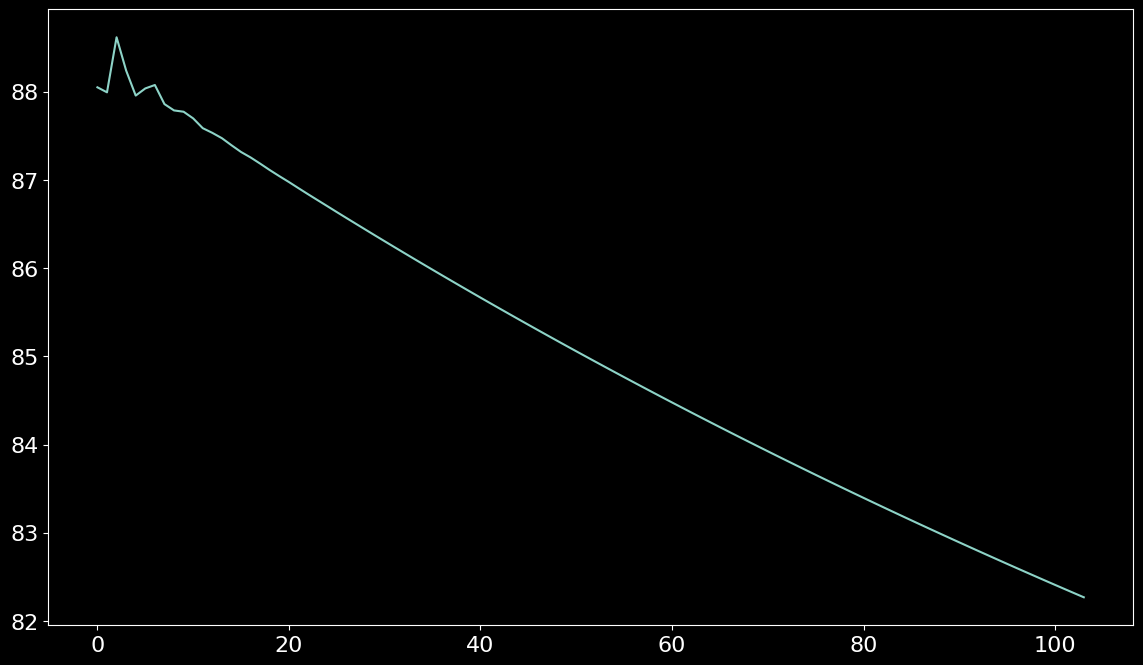

In [120]:
roll.plot()

In [132]:
avg = data['close'].rolling(200).mean()
avg_off = avg.shift(-100)

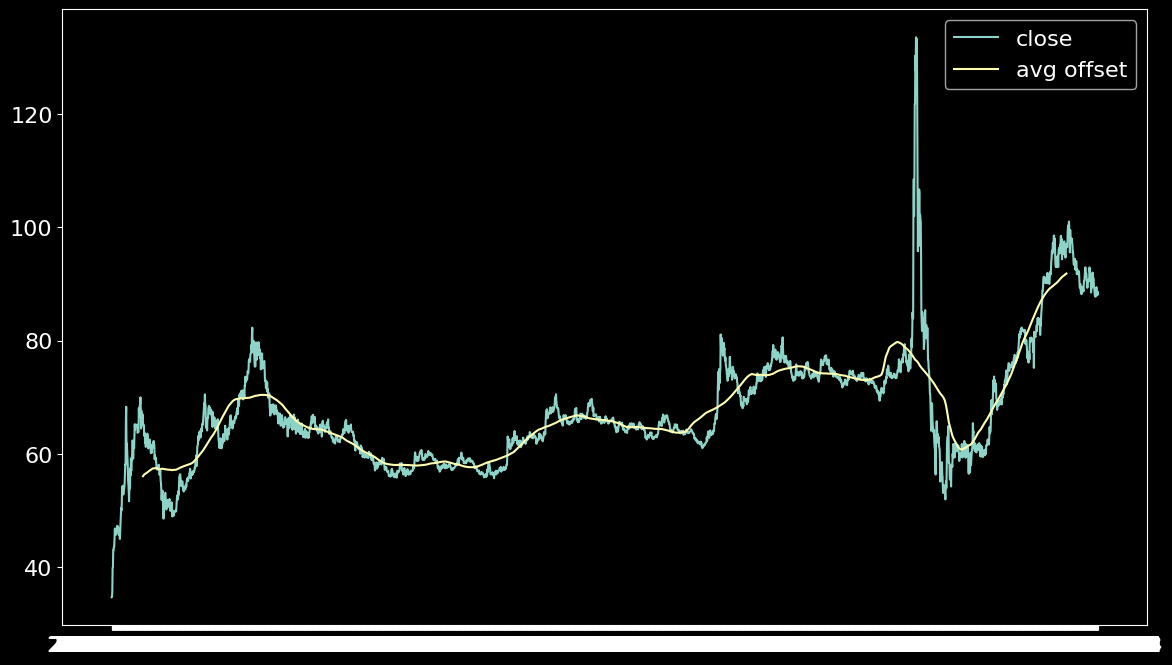

In [133]:
plt.plot(data['close'], label="close")
plt.plot(avg_off, label="avg offset")
plt.legend()
plt.show()

In [131]:
data.close.shape

(3122,)

In [134]:
avg_off.shape

(3122,)

In [138]:
data["avg"] = avg_off
data1 = data.dropna()

In [139]:
data1.shape

(2923, 6)

In [141]:
train_length1 = int(len(data1) * 0.8)
print('Train length: ', train_length1)

train_data1, test_data1 = data1[:train_length1], data1[train_length1:]
print('Shape of Train and Test data: ', len(train_data1), len(test_data1))

Train length:  2338
Shape of Train and Test data:  2338 585


In [142]:
train_X1, train_y1 = split_sequence(train_data1['avg'], lag)
test_X1, test_y1 = split_sequence(test_data1['avg'], lag)

C:\Users\igor\AppData\Local\Temp\ipykernel_13044\1544843132.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]


In [143]:
train_X1 = train_X1.reshape((train_X1.shape[0], train_X1.shape[1], n_features))
test_X1 = test_X1.reshape((test_X1.shape[0], test_X1.shape[1], n_features))

In [148]:
# # ok params
model = Sequential()
model.add(LSTM(16, 
               activation='relu', 
              #  dropout=0.7, 
               return_sequences=False, 
               input_shape=(lag, n_features))
)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

c:\Users\igor\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 16)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,169 (4.57 KB)

 Trainable params: 1,169 (4.57 KB)

 Non-trainable params: 0 (0.00 B)

In [149]:
history = model.fit(train_X1, train_y1, epochs = 3, batch_size=8, verbose=1, validation_split= 0.2)

Epoch 1/3


234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1989.6455 - val_loss: 1.3512
Epoch 2/3
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 0.1724 - val_loss: 0.5900
Epoch 3/3
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 0.0671 - val_loss: 0.0277


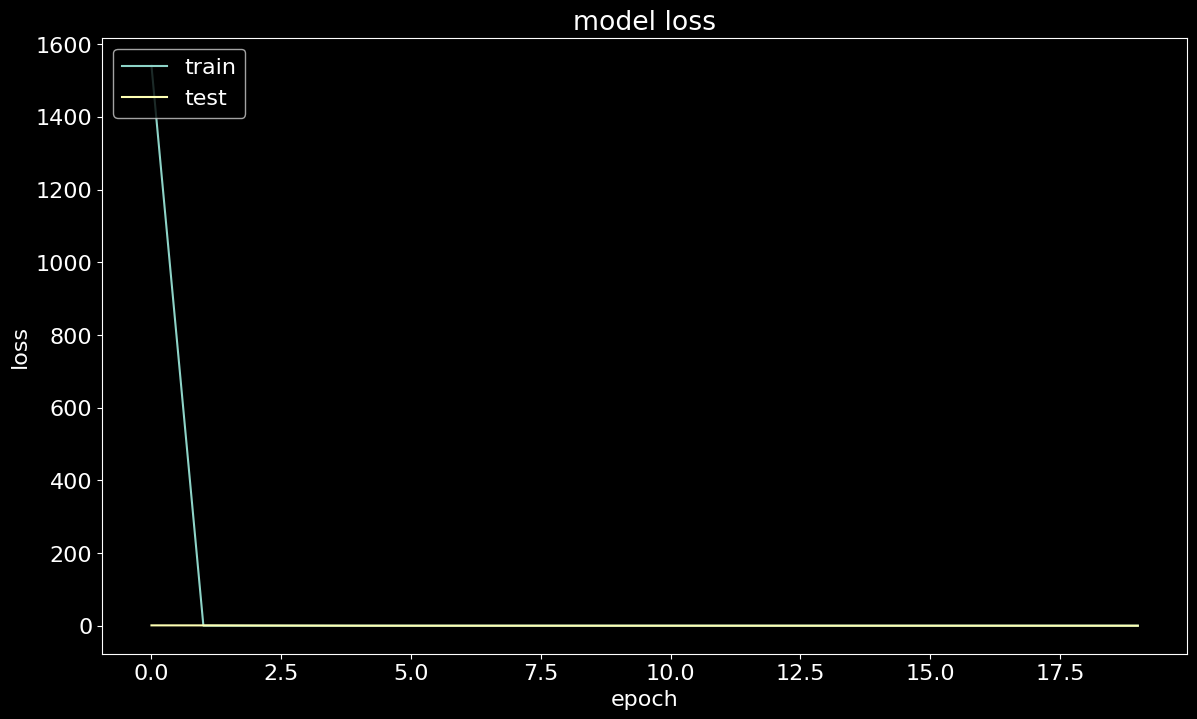

In [146]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [150]:
train_predict1 = model.predict(train_X1)
test_predict1 = model.predict(test_X1)

print('Shape of train and test predict: ', train_predict1.shape, test_predict1.shape)

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step
Shape of train and test predict:  (2335, 1) (582, 1)


In [151]:
train_score1 = measure_rmse(train_y1, train_predict1)
test_score1 = measure_rmse(test_y1, test_predict1)

train_score_mape1 = measure_mape(train_y1, train_predict1)
test_score_mape1 = measure_mape(test_y1, test_predict1)

print('Train and Test RMSE: ', train_score1, test_score1)
print('Train and Test MAPE: ', train_score_mape1, test_score_mape1)

Train and Test RMSE:  0.12775031521908475 0.4122478240071013
Train and Test MAPE:  0.038457539306661376 0.06909049763849671


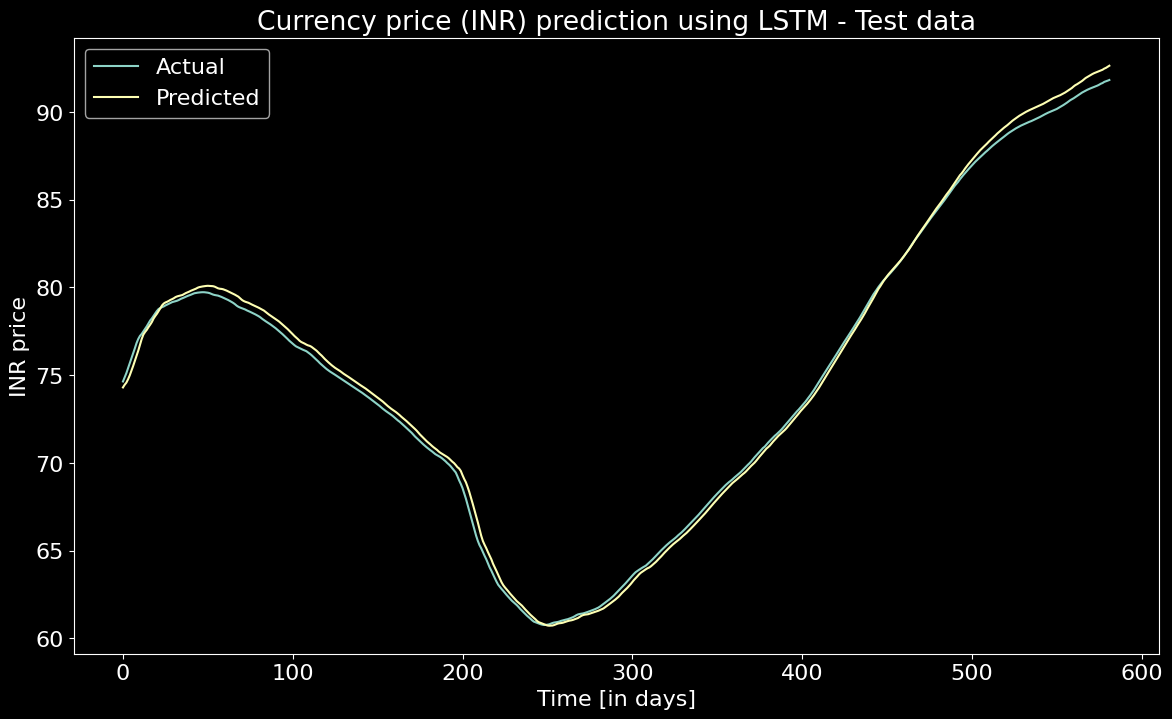

In [152]:
plt.rc("figure", figsize=(14,8))
plt.rcParams.update({'font.size': 16})
plt.plot(test_y1, label = 'Actual')
plt.plot(test_predict1, label = 'Predicted')
plt.xlabel('Time [in days]')
plt.ylabel('INR price')
plt.title('Currency price (INR) prediction using LSTM - Test data')
plt.legend()
plt.show()

In [165]:
data1['avg'].tail(4)

date
2023-09-24    91.713819
2023-09-25    91.746042
2023-09-26    91.784137
2023-09-27    91.821386
Name: avg, dtype: float64

In [154]:
roll = data1['avg'].tail(4).reset_index(drop=True)

for i in range(100):
  last = split_sequence_v2(roll.tail(4), lag)
  last = last.reshape((last.shape[0], last.shape[1], n_features))
  last_pred = model.predict(last)
  roll = pd.concat([roll, pd.Series(last_pred[0])], ignore_index=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

<Axes: >

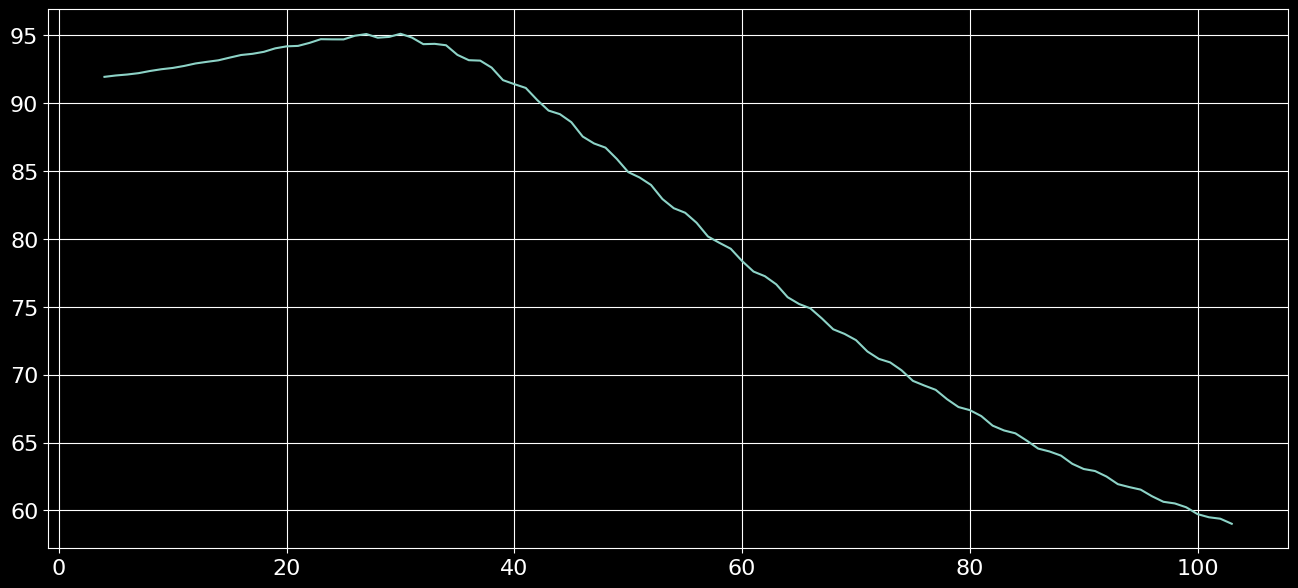

In [164]:
roll.rolling(5).mean().ewm(alpha=0.1).mean().plot(figsize=(16,7), grid=True)

<Axes: >

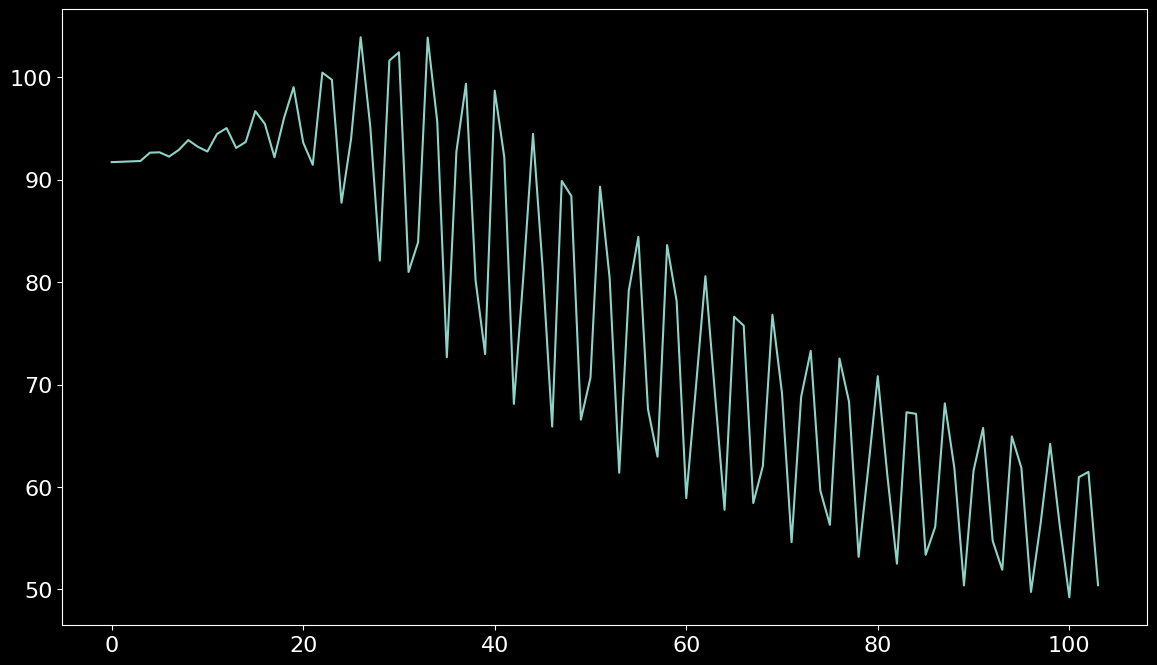

In [155]:
roll.plot()